In [2]:
from sklearn.decomposition import KernelPCA,PCA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import cross_validate
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold,SelectKBest,mutual_info_classif

In [12]:
# Feature selection method : mutual info ranking
# parameter w: number of feature selected after feature selection, the top w features
# parameter K_new_X,K_new_y: data and labels after kernelPCA
# return P_new_X,P_new_y
def mutual_info_FS(K_new_X,K_new_y,w):
    score = mutual_info_classif(K_new_X,K_new_y).tolist()
    dic = {}
    size = K_new_X.shape[1]
    for i in range(size):
        l = K_new_X[:,i].tolist()
        l = [score[i]] + l
        dic[i] = l
    dic = dict(sorted(dic.items(), key=lambda x: x[1][0], reverse=True))
    dic_kept = {}
    for i in dic.keys():
        dic_kept[i] = []
    temp = np.array(list(dic.values()))[:,1:].T[:,:w]
    P_new_X,P_new_y = temp,K_new_y
    return P_new_X,P_new_y,dic_kept

In [13]:
# Cross validation to improve the feature selection
# cross validation on test set to find the optimal w
# return optimal w
def cv_w(K_new_X,K_new_y,k_range,w_range):
    dic = {}
    for w in w_range:
        input_X,input_y,dic_kept = mutual_info_FS(K_new_X,K_new_y,w)
        tem_score = []
        for k in k_range:
            model = KNN(k)
            cv_results = cross_validate(model,input_X,input_y,cv = 5)
            tem_score.append(sum(cv_results['test_score'].tolist())/len(cv_results['test_score'].tolist()))
        avg = sum(tem_score)/len(tem_score)
        dic[w] = avg
    dic_sorted = sorted(dic.items(),reverse = True)
    opt_w = dic_sorted[0][0]
    return opt_w

In [14]:
# parameter X: data array of shape(n_sample,n_feature)
# parameter y: labels of shape(n_samples,)
# parameter kernel: kernerl used for each layer (here is fixed for arccosine)
# parameter classifier: classifier used for the output layer
# parameter arc_order: the order of activation function and arccosine kernel
# return the trained MKM model

# classified by KNN with cv

def MKM(X,y,l,kernel,classifier):
    New_X,New_y = X,y
    print(New_X.shape)
    KPCA_list = []
    FS_list = []
    w_list = []
    for i in range(l):
        size = New_X.shape[1]
        # K-layer
        KPCA = KernelPCA(n_components = size-80, kernel = kernel)
        K_new_X,K_new_y = KPCA.fit_transform(New_X),New_y
#         pca = PCA(n_components = size-80)
#         K_new_X,K_new_y = pca.fit_transform(New_X),New_y
        # Bookkeeping the KPCA model used in each layer
        KPCA_list.append(KPCA)
#         KPCA_list.append(pca)
        # P-layer
#         w = cv_w(K_new_X,K_new_y,range(1,4),range(10,30,5))
#         w_list.append(w)
#         P_new_X,P_new_y,dic_kept = mutual_info_FS(K_new_X,K_new_y,size-80-w)
#         P_new_X,P_new_y,dic_kept = mutual_info_FS(K_new_X,K_new_y,size-100)
#         FS_list.append(dic_kept)
#         New_X,New_y = P_new_X,P_new_y
        New_X,New_y = K_new_X,K_new_y
        print('Train Layer {} Done!'.format(i+1))
        print('Data has the shape {}'.format(New_X.shape))
    final_X, final_y =  New_X, New_y
    model = classifier.fit(final_X, final_y)
    print('Model has been successfully trained!')
    print('----------------------------------------------------------------------')
    return model,KPCA_list,FS_list,w_list

In [15]:
# parameter X: data array of shape(n_sample,n_feature)
# parameter y: labels of shape(n_samples,)
# parameter data_test_X: data array of shape(n_sample,n_feature)
# parameter data_test_y: labels of shape(n_samples,)
# parameter l: the number of layers of kernel machines
# parameter MKM: the trained MKM model
# parameter kernel: kernerl used for each layer (here is fixed for arccosine)
# parameter arc_order: the order of activation function and arccosine kernel
# return accuracy score for test set

# classified by KNN with cv

def MKM__test(X,y,l,KPCA_list,FS_list,w_list,MKM):
    New_X,New_y = X,y
    for i in range(l):
        size = New_X.shape[1]
        dic_feature = {}
        for f in range(size):
            dic_feature[f] = New_X[:,f]
        # K-layer
        K_new_X,K_new_y = KPCA_list[i].transform(New_X),New_y
        # P-layer
#         w = cv_w(K_new_X,K_new_y,range(1,15),range(10,300))
#         P_new_X,P_new_y = mutual_info_FS(K_new_X,K_new_y,w)
#         for key in FS_list[i].keys():
#             FS_list[i][key] = dic_feature[key]
#         temp = np.array(list(FS_list[i].values())).T[:,:size-80-w_list[i]]
#         temp = np.array(list(FS_list[i].values())).T[:,:size-100]
#         P_new_X,P_new_y = temp,K_new_y
#         New_X,New_y = P_new_X,P_new_y
        New_X,New_y = K_new_X,K_new_y
        print('Test Layer {} Done!'.format(i+1))
        print('Data has the shape {}'.format(New_X.shape))
    final_X, final_y =  New_X, New_y
    predict_y = MKM.predict(final_X)
    print(accuracy_score(final_y,predict_y))
    print('Test is finished!')
    print('----------------------------------------------------------------------')
    return accuracy_score(final_y,predict_y)

In [3]:
data = pd.read_csv('mnist_test.csv',header = None).iloc[5000:,:].sample(n=4000)
data_X = data.iloc[:,1:].to_numpy()
data_y = data.iloc[:,0].to_numpy()
data_test = pd.read_csv('mnist_test.csv',header = None).iloc[:5000,:].sample(n=1000)
data_test_X = data_test.iloc[:,1:].to_numpy()
data_test_y = data_test.iloc[:,0].to_numpy()

In [16]:
model, KPCA_list ,FS_list,w_list= MKM(data_X,data_y,1,'linear',KNN(10))

(3000, 784)
Train Layer 1 Done!
Data has the shape (3000, 704)
Model has been successfully trained!
----------------------------------------------------------------------


In [17]:
MKM__test(data_test_X,data_test_y,1,KPCA_list,FS_list,w_list,model)

Test Layer 1 Done!
Data has the shape (1000, 704)
0.929
Test is finished!
----------------------------------------------------------------------


0.929

In [11]:
# Calculate accuracy score for Only PCA 1 layer + KNN
accu_score_1 = []
# number of layers
for i in range(50,100,10):
    print('KNN ({})'.format(i))
    # datasets test to ensure robust
    accu_score_temp = []
    for d in range(5):
        # load and sample the training and test dataset
        data = pd.read_csv('mnist_test.csv',header = None).iloc[:5000,:].sample(n=3000)
        data_X = data.iloc[:,1:].to_numpy()
        data_y = data.iloc[:,0].to_numpy()
        data_test = pd.read_csv('mnist_test.csv',header = None).iloc[5000:,:].sample(n=1000)
        data_test_X = data_test.iloc[:,1:].to_numpy()
        data_test_y = data_test.iloc[:,0].to_numpy()
        
        model, KPCA_list ,FS_list,w_list = MKM(data_X,data_y,1,kernel = 'linear' ,classifier = KNN(i))
        accu_score_temp.append(MKM__test(data_test_X,data_test_y,1,
                                        KPCA_list = KPCA_list,FS_list = FS_list,
                                        w_list = w_list,MKM = model))
    accu_score_1.append(np.round(sum(accu_score_temp)/len(accu_score_temp),3))
    print('----------------------------------------------------------------')

KNN (50)
(3000, 784)
Train Layer 1 Done!
Data has the shape (3000, 704)
Model has been successfully trained!
----------------------------------------------------------------------
Test Layer 1 Done!
Data has the shape (1000, 704)
0.89
Test is finished!
----------------------------------------------------------------------
(3000, 784)
Train Layer 1 Done!
Data has the shape (3000, 704)
Model has been successfully trained!
----------------------------------------------------------------------
Test Layer 1 Done!
Data has the shape (1000, 704)
0.867
Test is finished!
----------------------------------------------------------------------
(3000, 784)
Train Layer 1 Done!
Data has the shape (3000, 704)
Model has been successfully trained!
----------------------------------------------------------------------
Test Layer 1 Done!
Data has the shape (1000, 704)
0.895
Test is finished!
----------------------------------------------------------------------
(3000, 784)
Train Layer 1 Done!
Data has the

KeyboardInterrupt: 

In [8]:
# Calculate accuracy score for Only PCA 2 layer + KNN
accu_score_2 = []
# number of layers
for i in range(50,100,10):
    print('KNN ({})'.format(i))
    # datasets test to ensure robust
    accu_score_temp = []
    for d in range(5):
        # load and sample the training and test dataset
        data = pd.read_csv('mnist_test.csv',header = None).iloc[:5000,:].sample(n=3000)
        data_X = data.iloc[:,1:].to_numpy()
        data_y = data.iloc[:,0].to_numpy()
        data_test = pd.read_csv('mnist_test.csv',header = None).iloc[5000:,:].sample(n=1000)
        data_test_X = data_test.iloc[:,1:].to_numpy()
        data_test_y = data_test.iloc[:,0].to_numpy()
        
        model, KPCA_list ,FS_list,w_list = MKM(data_X,data_y,1,kernel = 'linear' ,classifier = KNN(i))
        accu_score_temp.append(MKM__test(data_test_X,data_test_y,1,
                                        KPCA_list = KPCA_list,FS_list = FS_list,
                                        w_list = w_list,MKM = model))
    accu_score_2.append(np.round(sum(accu_score_temp)/len(accu_score_temp),3))
    print('----------------------------------------------------------------')

KNN (50)
(3000, 784)
Train Layer 1 Done!
Data has the shape (3000, 704)
Model has been successfully trained!
----------------------------------------------------------------------
Test Layer 1 Done!
Data has the shape (1000, 704)
0.881
Test is finished!
----------------------------------------------------------------------
(3000, 784)
Train Layer 1 Done!
Data has the shape (3000, 704)
Model has been successfully trained!
----------------------------------------------------------------------
Test Layer 1 Done!
Data has the shape (1000, 704)
0.895
Test is finished!
----------------------------------------------------------------------
(3000, 784)
Train Layer 1 Done!
Data has the shape (3000, 704)
Model has been successfully trained!
----------------------------------------------------------------------
Test Layer 1 Done!
Data has the shape (1000, 704)
0.905
Test is finished!
----------------------------------------------------------------------
(3000, 784)
Train Layer 1 Done!
Data has th

In [9]:
# Calculate accuracy score for Only PCA 3 layer + KNN
accu_score_3 = []
# number of layers
for i in range(50,100,10):
    print('KNN ({})'.format(i))
    # datasets test to ensure robust
    accu_score_temp = []
    for d in range(5):
        # load and sample the training and test dataset
        data = pd.read_csv('mnist_test.csv',header = None).iloc[:5000,:].sample(n=3000)
        data_X = data.iloc[:,1:].to_numpy()
        data_y = data.iloc[:,0].to_numpy()
        data_test = pd.read_csv('mnist_test.csv',header = None).iloc[5000:,:].sample(n=1000)
        data_test_X = data_test.iloc[:,1:].to_numpy()
        data_test_y = data_test.iloc[:,0].to_numpy()
        
        model, KPCA_list ,FS_list,w_list = MKM(data_X,data_y,1,kernel = 'linear' ,classifier = KNN(i))
        accu_score_temp.append(MKM__test(data_test_X,data_test_y,1,
                                        KPCA_list = KPCA_list,FS_list = FS_list,
                                        w_list = w_list,MKM = model))
    accu_score_3.append(np.round(sum(accu_score_temp)/len(accu_score_temp),3))
    print('----------------------------------------------------------------')

KNN (50)
(3000, 784)
Train Layer 1 Done!
Data has the shape (3000, 704)
Model has been successfully trained!
----------------------------------------------------------------------
Test Layer 1 Done!
Data has the shape (1000, 704)
0.894
Test is finished!
----------------------------------------------------------------------
(3000, 784)
Train Layer 1 Done!
Data has the shape (3000, 704)
Model has been successfully trained!
----------------------------------------------------------------------
Test Layer 1 Done!
Data has the shape (1000, 704)
0.886
Test is finished!
----------------------------------------------------------------------
(3000, 784)
Train Layer 1 Done!
Data has the shape (3000, 704)
Model has been successfully trained!
----------------------------------------------------------------------
Test Layer 1 Done!
Data has the shape (1000, 704)
0.886
Test is finished!
----------------------------------------------------------------------
(3000, 784)
Train Layer 1 Done!
Data has th

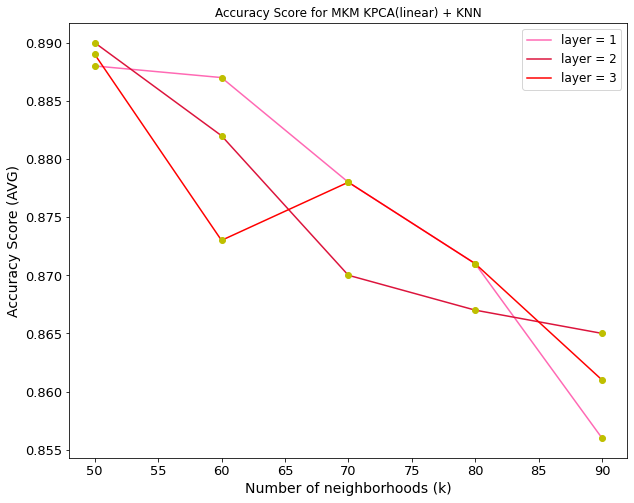

In [10]:
# plot the accuracy score for arccosine kernel: 3 line 1 picture
x_axis = range(50,100,10)
fig,axes = plt.subplots(figsize = (10,8))
sns.lineplot(x = x_axis, y = accu_score_1,color = 'hotpink',label = 'layer = 1')
sns.lineplot(x = x_axis, y = accu_score_2,color = 'crimson',label = 'layer = 2')
sns.lineplot(x = x_axis, y = accu_score_3,color = 'red',label = 'layer = 3')

plt.plot(x_axis,accu_score_1, 'yo')
plt.plot(x_axis,accu_score_2, 'yo')
plt.plot(x_axis,accu_score_3, 'yo')

plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.xlabel(r'Number of neighborhoods (k)',fontsize = 14)
plt.ylabel('Accuracy Score (AVG)',fontsize = 14)
plt.legend(loc = 'upper right',prop={'size': 12})
plt.title('Accuracy Score for MKM KPCA(linear) + KNN')
fig.savefig('MKM_KPCA + KNN_varLayer',bbox_inches = 'tight',dpi = 100)